In [1]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, SequentialSampler

from datasets import SASRecDataset
from models import S3RecModel
from trainers import FinetuneTrainer
from utils import (
    check_path,
    generate_submission_file,
    get_item2attribute_json,
    get_user_seqs,
    set_seed,
    __save_labels
)

In [2]:
from collections import namedtuple
args = namedtuple("Config", [])

args.data_dir = "../../../data/train-8/"
args.output_dir = "output-batch16-hiddensize32/"

args.data_name  = "rb"
args.model_name = "Finetune_full"
args.hidden_size = 32 #64 # hidden size of transformer model
args.num_hidden_layers = 2 #2 # number of layers
args.num_attention_heads = 2 # num_attention_heads
args.hidden_act = "gelu"
args.attention_probs_dropout_prob = 0.5 # attention dropout p
args.hidden_dropout_prob = 0.5 # hidden dropout p
args.initializer_range=0.02
args.max_seq_length= 500 #1000 #500 #50

# train args
args.lr=0.001 # "learning rate of adam"
args.batch_size= 128 #256 # number of batch_size"
args.epochs=200#"number of epochs")
args.log_freq=1 #per epoch print res")
args.seed=42
args.weight_decay=0.0 #, help="weight_decay of adam"
args.adam_beta1=0.9 #"adam first beta value"
args.adam_beta2=0.999 #"adam second beta value"
args.gpu_id="0"#"gpu_id"

In [3]:
set_seed(args.seed)
check_path(args.output_dir) # output_dir 로 설정한 경로가 없으면 생성

args.no_cuda = False # gpu 있음
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu_id
args.cuda_condition = torch.cuda.is_available() and not args.no_cuda

args.data_file = args.data_dir + "train_ratings.csv"
item2attribute_file = args.data_dir + args.data_name + "_item2attributes.json"

rating_df = pd.read_csv(args.data_file)

le = LabelEncoder()
label_path = os.path.join(args.output_dir, "item" + "_classes.npy") # args.asset_dir -> args.output_dir
le.classes_ = np.load(label_path)
rating_df["item"] = le.transform(rating_df["item"])

# save model args
args_str = f"{args.model_name}-{args.data_name}"
checkpoint = args_str + ".pt"
args.checkpoint_path = os.path.join(args.output_dir, checkpoint)

# max_item # 
user_seq, rating_seq, max_item, valid_rating_matrix, test_rating_matrix, _ = get_user_seqs(
    args, # args.data_file, args.output_dir
    is_train = False
)
item2attribute, attribute_size = get_item2attribute_json(item2attribute_file)

In [4]:
args.item_size = max_item + 2
args.mask_id = max_item + 1
args.attribute_size = attribute_size + 1

model = S3RecModel(args=args)

file_name = args.checkpoint_path
model.load_state_dict(torch.load(file_name))

model = model.to(device="cuda:0")

### 가상의 맥주 input 데이터 생성

In [5]:
# 우리 결과는 총 81개의 맥주로 한정되어있다. 
# 우리는 초기에 유저에 대한 정보를 수집할 때, 최대 29개의 맥주를 선정하도록 되어있다. 

# 81개의 맥주에 대해서 1 ~ 29개의 다양한 선택지를 (불, 호 도 포함하는 데이터)

In [6]:
# 우리의 대상이 되는 맥주
target_beer_df = pd.read_csv("/opt/ml/workspace/final-project-level3-recsys-10/data/db_files/db_target_beer.csv")
target_beer_list = target_beer_df["beer_id"].astype(int).tolist()
target_beer_list[:5]

[8666, 75661, 614833, 169964, 251]

In [7]:
# 유저들의 긍정 응답 비율
p_pos = 0.673605

# 유저들의 응답 개수의 평균, 편차
n_pick_mean = 9.608
n_pick_std = 9.215953908934923

# target_beer_list -> encoding
encoded_target_beer_arr = le.transform(target_beer_list)

np.random.seed(42)

item_lists = []
rate_lists = []

for i in range(50000):
    # n_size from normalization
    n_size = int(n_pick_mean + np.random.randn()*n_pick_std)
    if n_size <= 0 :
        n_size = 1
    elif n_size >= 30:
        n_size = 30
    
    cand_item_list = np.random.choice(encoded_target_beer_arr, size=n_size, replace=False).tolist()
    cand_rate_list = np.random.choice((5, 1), size=n_size, replace=True, p=(p_pos, 1-p_pos)).tolist()
    
    item_lists.append(cand_item_list)
    rate_lists.append(cand_rate_list)

<AxesSubplot:>

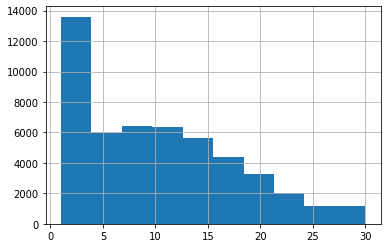

In [8]:
pd.Series([len(item_list) for item_list in item_lists]).hist()

In [9]:
from torch.utils.data import Dataset

class TestDataset(Dataset):
    def __init__(self, args):
        self.max_len = args.max_seq_length

        self.item_lists = item_lists
        self.rate_lists = rate_lists

    def __len__(self):
        return len(self.item_lists) # 유저의 수
    
    def __getitem__(self, index):
        input_item_seq = self.item_lists[index]
        input_item_rating = self.rate_lists[index]

        pad_len = self.max_len - len(input_item_seq)
        input_item_seq = [0] * pad_len + input_item_seq
        input_item_rating = [0] * pad_len + input_item_rating

        input_item_seq = input_item_seq[-self.max_len :]
        input_item_rating = input_item_rating[-self.max_len :]

        cur_tensors = (
            torch.tensor(input_item_seq, dtype=torch.long), # tobe batch_size * max_seq * emb
            torch.tensor(input_item_rating, dtype=torch.float32), # tobe batch_size * max_seq * emb
        )

        return cur_tensors

In [10]:
test_dataset = TestDataset(args)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(
    test_dataset, sampler=test_sampler, batch_size=args.batch_size, drop_last=False
)

In [14]:
device = "cuda:0"
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_items, input_ratings = batch

    recommend_output = model.finetune(input_items,  input_ratings)
    recommend_output = recommend_output[:, -1, :]

    result_scores = torch.matmul(model.item_embeddings.weight, recommend_output.transpose(0, 1)).squeeze(1)
    result_scores = result_scores.cpu().data.numpy().copy()

    # 결과 저장
    result_scores_without_pad = result_scores[1:]
    target_result = result_scores_without_pad[encoded_target_beer_arr]

    if i == 0:
        target_results = target_result
    else:
        target_results = np.concatenate((target_results, target_result), axis=1)

In [25]:
df_result = pd.DataFrame()
df_result["beer_id"] = target_beer_list
df_result["beer_id_encoded"] = encoded_target_beer_arr
df_result["avg"] = target_results.mean(axis=1)
df_result["std"] = target_results.std(axis=1)
df_result

,beer_id,beer_id_encoded,avg,std
0,8666,2423,3.449692,0.035444
1,75661,6837,2.994884,0.032212
2,614833,9333,2.308918,0.029562
3,169964,9320,2.130463,0.029876
4,251,149,2.306895,0.033953
...,...,...,...,...
76,7580,2171,3.316092,0.037749
77,452525,9328,0.278468,0.030140
78,1417,674,3.199151,0.039597
79,1486,696,3.092594,0.037932


In [26]:
df_result.to_csv("reg_info.csv", index=False)

In [19]:
target_results.mean(axis=1)
target_results.std(axis=1)


array([0.03544397, 0.03221208, 0.02956188, 0.02987643, 0.03395296,
       0.03444979, 0.03509032, 0.03166423, 0.0315886 , 0.03662518,
       0.03614352, 0.03751377, 0.04599313, 0.03533243, 0.02833471,
       0.03022837, 0.03317192, 0.03427517, 0.03324341, 0.0353226 ,
       0.02668307, 0.03190349, 0.04086716, 0.0413459 , 0.03912333,
       0.04200497, 0.03582472, 0.03442818, 0.03125061, 0.04198901,
       0.03527829, 0.03243998, 0.03805697, 0.0315554 , 0.02501035,
       0.03900801, 0.03858582, 0.03261737, 0.03519743, 0.04237026,
       0.03285498, 0.0331634 , 0.03287557, 0.02324456, 0.04085466,
       0.03606223, 0.04038198, 0.02628915, 0.03602189, 0.04003613,
       0.03151063, 0.03042013, 0.03907518, 0.0377388 , 0.03301377,
       0.03137554, 0.03567226, 0.02583801, 0.03562443, 0.02889054,
       0.0309057 , 0.03326613, 0.02835379, 0.03410296, 0.03911958,
       0.0385016 , 0.0314107 , 0.04296244, 0.03739556, 0.03356086,
       0.02791958, 0.03274544, 0.0334294 , 0.03575925, 0.03323

In [13]:
result_scores_without_pad = result_scores[1:]
result_scores_without_pad[encoded_target_beer_arr]

len(np.concatenate((result_scores_without_pad[encoded_target_beer_arr], result_scores_without_pad[encoded_target_beer_arr]), axis=1))

81